In [136]:
# Allows code to live reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Install
```sh
# Install prerequisites
pip install pyodc

```

## 2. Make an ECMWF account
- Go to ecmwf.int/, click login at the top right and click register to make a new account.
- Once logged in, go to api.ecmwf.int/v1/key/ to get your key. 
- Put it in `~/.ecmwfapirc` as directed.

In [137]:
# Load in the ECMWF token 
from pathlib import Path
import json
import requests
from IPython.display import JSON, display
from datetime import datetime as dt
from datetime import timedelta, timezone
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

with open(Path("~/.ecmwfapirc").expanduser(), "r") as f:
    api_creds = json.load(f)

print("Checking API credentials")
r = requests.get(f"https://api.ecmwf.int/v1/who-am-i?token={api_creds['key']}")
if r.status_code == 403: print("Your credentials are either wrong or need to be renewed at https://api.ecmwf.int/v1/key/")
r.raise_for_status()
JSON(r.json())

Checking API credentials


<IPython.core.display.JSON object>

In [138]:
session = requests.Session()
session.headers["Authorization"] = f"Bearer {api_creds['key']}"

# API Endpoint

Documentation http://ionbeam-ichange.ecmwf-ichange.f.ewcloud.host/docs

In [139]:
# url = "http://ionbeam-ichange.ecmwf-ichange.f.ewcloud.host/api/v1/"
url = "http://localhost:5002/api/v1/"

### Get all stations

In [140]:
from datetime import datetime

stations = session.get(url + "stations", params = dict(platform = "acronet")).json()
print(f"{len(stations) = }")

len(stations) = 99


In [141]:
import folium

map = folium.Map(location=[44.226414, 9.532785], zoom_start=7)

for station in stations:
    p = station["location"]
    folium.CircleMarker(
        location=(station["location"]["lat"], station["location"]["lon"]),
        popup = station,
        radius=5, fill_color="orange", fill_opacity=0.4, color="black", weight=1,
    ).add_to(map)

map

In [142]:
stations[0]

{'name': 'Rifugio Argentea',
 'description': 'An Acronet station',
 'platform': 'acronet',
 'external_id': 'rifugio_argentea',
 'internal_id': 'cbf531dac07bddb4',
 'location': {'lat': 44.43832, 'lon': 8.641541},
 'time_span': {'start': '2025-01-11T11:57:00Z', 'end': '2025-01-15T15:44:00Z'},
 'authors': [{'name': 'acronet'}],
 'mars_request': {'class': 'rd',
  'expver': 'xxxx',
  'stream': 'lwda',
  'aggregation_type': 'chunked',
  'date': '20250111/to/20250115/by/1',
  'platform': 'acronet',
  'internal_id': 'cbf531dac07bddb4'}}

### Get stations with recent data

In [143]:
%%time
from datetime import datetime, timedelta, UTC

recent_stations = session.get(url + "stations", params = {
    "start_time" : datetime.now(UTC) - timedelta(hours = 3),
    "platform" : "acronet",
}).json()
print(f"data ingested in last hour: {len(recent_stations) = }")

data ingested in last hour: len(recent_stations) = 99
CPU times: user 2.02 ms, sys: 1.04 ms, total: 3.06 ms
Wall time: 125 ms


In [144]:
granules = session.get(url + "list").json()
print(f"{len(granules) = }")

len(granules) = 6750


In [145]:
print(json.dumps(
    sorted(recent_stations, key = lambda s : datetime.fromisoformat(s["time_span"]["end"]) )[-1],
indent = 4))

{
    "name": "Torre Civica",
    "description": "An Acronet station",
    "platform": "acronet",
    "external_id": "torre_civica",
    "internal_id": "759dbff9fe4985cd",
    "location": {
        "lat": 44.364265,
        "lon": 8.205334
    },
    "time_span": {
        "start": "2025-01-11T11:57:00Z",
        "end": "2025-01-15T15:44:00Z"
    },
    "authors": [
        {
            "name": "acronet"
        }
    ],
    "mars_request": {
        "class": "rd",
        "expver": "xxxx",
        "stream": "lwda",
        "aggregation_type": "chunked",
        "date": "20250111/to/20250115/by/1",
        "platform": "acronet",
        "internal_id": "759dbff9fe4985cd"
    }
}


In [146]:
[station["name"] for station in by_platform["acronet"]][:10] + [f"... {len(by_platform["acronet"])} in total"]

['Scuola Primaria Villa Sanguineti (Teglia)',
 'Semaforo Nuovo',
 'Piazza IV Novembre',
 'Via Fiume',
 'Stazione Rialto',
 'Scuola Stella San Giovanni',
 'Sambuco',
 'Termi',
 'Campi Sportivi Pigna',
 'Viale Rimembranze',
 '... 99 in total']

In [147]:
from random import choice

example_station = choice(by_platform["acronet"])
example_station

{'name': 'Campi Sportivi Pigna',
 'description': 'An Acronet station',
 'platform': 'acronet',
 'external_id': 'campi_sportivi_pigna',
 'internal_id': '3107c0e6dad80774',
 'location': {'lat': 43.930916, 'lon': 7.666303},
 'time_span': {'start': '2025-01-14T19:08:00Z', 'end': '2025-01-15T14:58:00Z'},
 'authors': [{'name': 'acronet'}],
 'mars_request': {'class': 'rd',
  'expver': 'xxxx',
  'stream': 'lwda',
  'aggregation_type': 'chunked',
  'date': '20250114/to/20250115/by/1',
  'platform': 'acronet',
  'internal_id': '3107c0e6dad80774'}}

### Data granules corresponging to an acronet station

In [148]:
data_granules = session.get(url + "list", params = example_station["mars_request"]).json()
datetimes = [(g["mars_request"]["date"], g["mars_request"]["time"]) for g in data_granules]
assert len(datetimes) == len(set(datetimes))
datetimes

[('20250114', '1800'),
 ('20250114', '1900'),
 ('20250114', '2000'),
 ('20250114', '2100'),
 ('20250114', '2200'),
 ('20250114', '2300'),
 ('20250115', '0000'),
 ('20250115', '0100'),
 ('20250115', '0200'),
 ('20250115', '0300'),
 ('20250115', '0400'),
 ('20250115', '0500'),
 ('20250115', '0600'),
 ('20250115', '0700'),
 ('20250115', '0800'),
 ('20250115', '0900'),
 ('20250115', '1000'),
 ('20250115', '1100'),
 ('20250115', '1200'),
 ('20250115', '1300'),
 ('20250115', '1400'),
 ('20250115', '1500')]

In [149]:
import folium
p = (example_station["location"]["lat"], example_station["location"]["lon"])
map = folium.Map(location=p, zoom_start=13)

# Add the point as a marker
folium.Marker(
    location=p,
    popup = example_station,
).add_to(map)
map

Giving the "mars_request" to the `list` endpoint gives the list of data granules available from the list endpoint. For the acronet data and other continuous streams, there is an additional key "time" which gives the begining of the interval in the format HHMM

In the MARS system one needs to deal with these separate `date` and `time` fields but for convenience two special arguments are added to the API: `start_time` and `end_time`, these ISO formatted fields will be used to return data granules within the defined temporal region.

* If `start_time` or `end_time` are supplied, `date` and `time` are ignored. 
* If `start_time` or `end_time` fall within the boundary of a data chunk, the whole chunk will be returned.
* If only one of `start_time` or `end_time` are supplied, the other is ignored.
  
* If neither `start_time` nor `end_time` are supplied, `date` and `time` will be used following the typical MARS language.

The `list` endpoint is not necessary, but can be useful to retrieve the available chunks for a mars request. The arguments to `list` and `retrieve` are the same, list returns what data granules exist and `retrieve` returns the data granules concatenated together.

### Getting data for an acronet station

In [150]:
example_station["mars_request"]

{'class': 'rd',
 'expver': 'xxxx',
 'stream': 'lwda',
 'aggregation_type': 'chunked',
 'date': '20250114/to/20250115/by/1',
 'platform': 'acronet',
 'internal_id': '3107c0e6dad80774'}

In [151]:
%%time

from io import BytesIO
example_station = by_platform["acronet"][-1]
now = datetime.now(UTC)
args = {
    "start_time" : (now - timedelta(hours = 5)).isoformat(),
    "end_time": (now - timedelta(hours = 0)).isoformat(),
}

granules = session.get(url + "list", params = example_station["mars_request"] | args).json()
data = session.get(url + "retrieve", params = example_station["mars_request"] | args | dict(format = "csv"))

if not data.ok:
    print("error: ", data.json())
else:
    df = pd.read_csv(BytesIO(data.content))
    df

CPU times: user 5.61 ms, sys: 5.45 ms, total: 11.1 ms
Wall time: 886 ms


In [152]:
df.columns

Index(['station_id', 'station_name', 'author', 'datetime', 'lat', 'lon',
       'wind_direction_near_surface', 'wind_speed_near_surface',
       'relative_humidity_near_surface', 'rainfall', 'battery_level',
       'air_temperature_near_surface', 'signal_strength', 'wind_gust'],
      dtype='object')

In [153]:
set(g["mars_request"]["internal_id"] for g in granules)
granules[-3:]

[{'mars_request': {'class': 'rd',
   'expver': 'xxxx',
   'stream': 'lwda',
   'aggregation_type': 'chunked',
   'date': '20250115',
   'internal_id': '06cd83f8ed2fd88b',
   'platform': 'acronet',
   'time': '1300',
   'version': '1'},
  'url': '/api/v1/retrieve?class=rd&expver=xxxx&stream=lwda&aggregation_type=chunked&date=20250115&internal_id=06cd83f8ed2fd88b&platform=acronet&time=1300&version=1',
  'datetime': '2025-01-15T13:00:00Z'},
 {'mars_request': {'class': 'rd',
   'expver': 'xxxx',
   'stream': 'lwda',
   'aggregation_type': 'chunked',
   'date': '20250115',
   'internal_id': '06cd83f8ed2fd88b',
   'platform': 'acronet',
   'time': '1400',
   'version': '1'},
  'url': '/api/v1/retrieve?class=rd&expver=xxxx&stream=lwda&aggregation_type=chunked&date=20250115&internal_id=06cd83f8ed2fd88b&platform=acronet&time=1400&version=1',
  'datetime': '2025-01-15T14:00:00Z'},
 {'mars_request': {'class': 'rd',
   'expver': 'xxxx',
   'stream': 'lwda',
   'aggregation_type': 'chunked',
   'da

### Plot showing data granule boundaries and station time span along with data

Any missing granules will show up as white areas

- Green vertical lines: data granule boundaries
- Green shaded: places we have data
- Black vertical lines: Station time span
- Red vertical lines: User timespan request

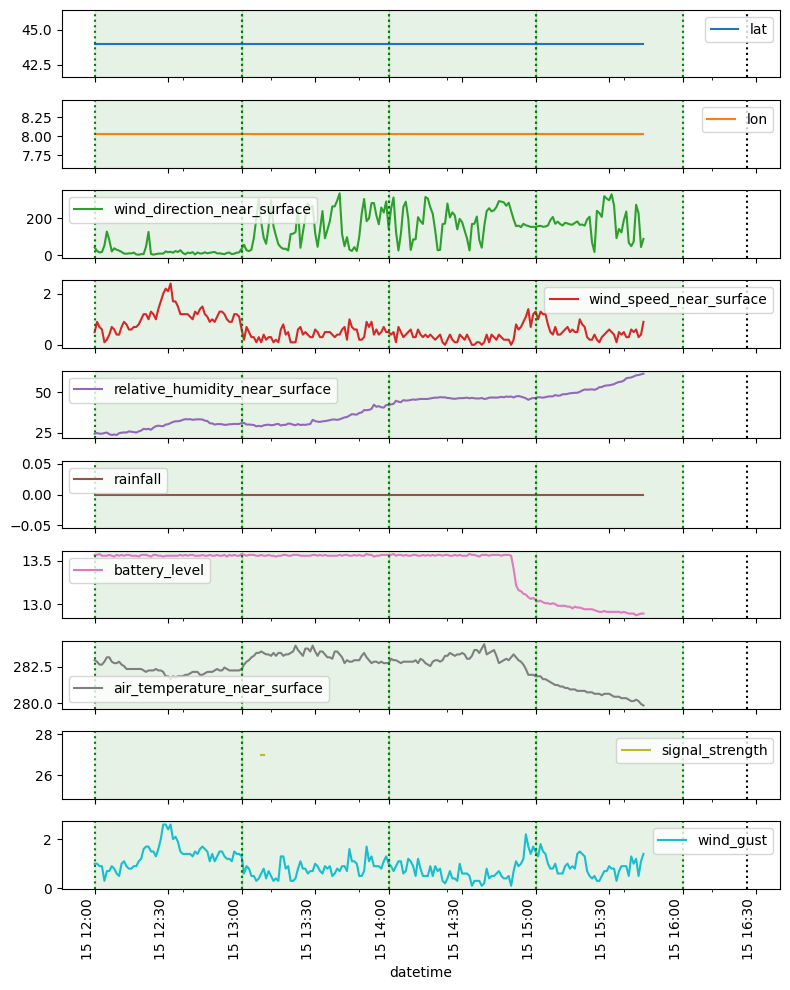

In [154]:
show_granule_boundaries = True

df["datetime"] = pd.to_datetime(df["datetime"])

ys_to_plot = df.select_dtypes(include='number').columns

axes = df.plot(
    x = "datetime",
    y = ys_to_plot,
    subplots=True, layout=(len(ys_to_plot), 1), figsize=(8, 1*len(ys_to_plot)), sharex=True, rot=90)

for ax in axes[:, 0]:
    if show_granule_boundaries:
        for g in granules:
            date, time = g["mars_request"]["date"], g["mars_request"]["time"]
            dt = datetime.strptime(date + time, "%Y%m%d%H%M")
            dt2 = dt + timedelta(minutes = 60)
            ax.axvline(dt, linestyle = "dotted", color = "green")
            ax.axvline(dt2, linestyle = "dotted", color = "green")
            ax.axvspan(dt, dt2, alpha = 0.1, color = "green")

    ax.axvline(datetime.now(UTC), linestyle = "dotted", color = "black")

    # for d in example_station["time_span"].values():
    #     ax.axvline(datetime.fromisoformat(d), linestyle = "dotted", color = "black")

    # ax.axvline(args["start_time"], linestyle = "dotted", color = "red")
    # ax.axvline(args["end_time"], linestyle = "dotted", color = "red")
    



plt.tight_layout()